Import Libraries to Load the Dataset

In [2]:
import numpy as np
from scipy import io as sio
import os

INDIAN PINES DATASET LOADING

In [3]:
data_folder = 'Datasets'
data_file= 'Indian_pines_corrected'
gt_file = 'Indian_pines_gt'
data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('indian_pines_corrected')
gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(145, 145, 200) (145, 145)


BASIC STATISTICS ON THE DATA

In [4]:
print("Mean:", np.mean(data_set))
print("Standard Deviation:", np.std(data_set))
print("Min Value:", np.min(data_set))
print("Max Value:", np.max(data_set))

Mean: 2652.3891098692034
Standard Deviation: 1592.3401203795752
Min Value: 955
Max Value: 9604


CLASS WISE ANALYSIS-CLASS DISTRIBUTION for IP

In [5]:
import matplotlib.pyplot as plt
# Display unique classes and their counts
classes, counts = np.unique(gt, return_counts=True)
print("Unique classes:", classes)
print("Class counts:", counts)

Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Class counts: [10776    46  1428   830   237   483   730    28   478    20   972  2455
   593   205  1265   386    93]


VISUALIZATION OF CLASS DISTRIBUTION

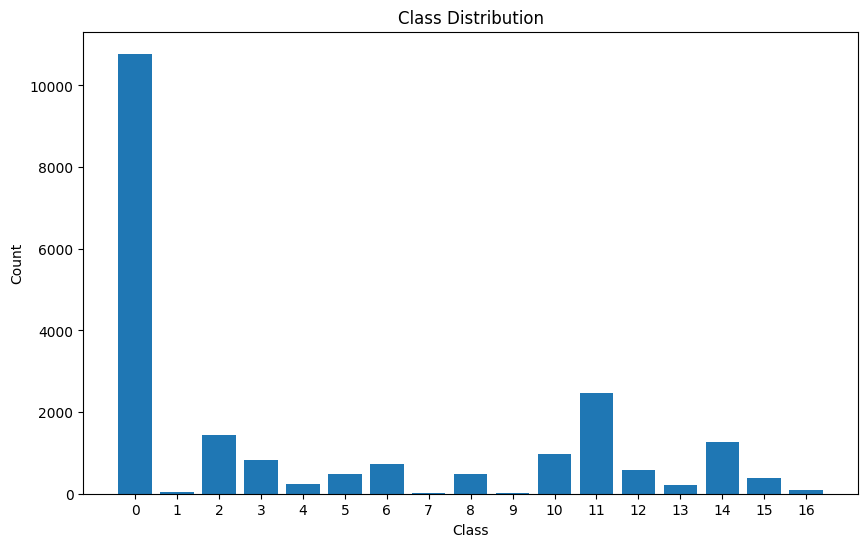

In [6]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xticks(np.arange(0, 17, 1)) 
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

SPECTRAL SIGNATURES OF EACH CLASS

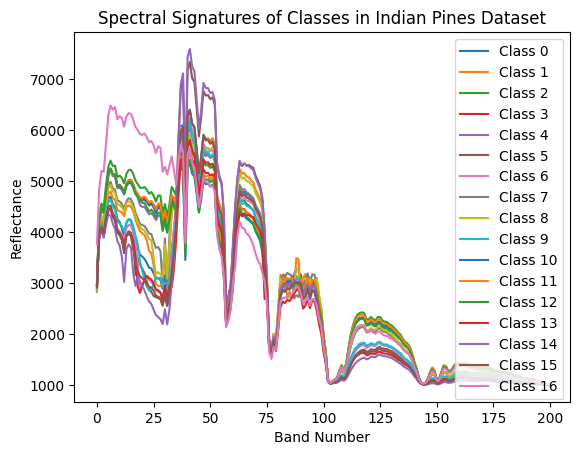

In [7]:
unique_labels = np.unique(gt)
#all classes together
# Plot spectral signatures of each class
for label in unique_labels:
    # Extract pixels belonging to the current class
    class_pixels = data_set[gt == label]
    # Calculate mean spectral signature for the class
    mean_signature = np.mean(class_pixels, axis=0)
    # Plot the spectral signature
    plt.plot(mean_signature, label=f'Class {label}')

# Customize plot
plt.title('Spectral Signatures of Classes in Indian Pines Dataset')
plt.xlabel('Band Number')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

VISUALIZING SOME BANDS IN THE DATASET

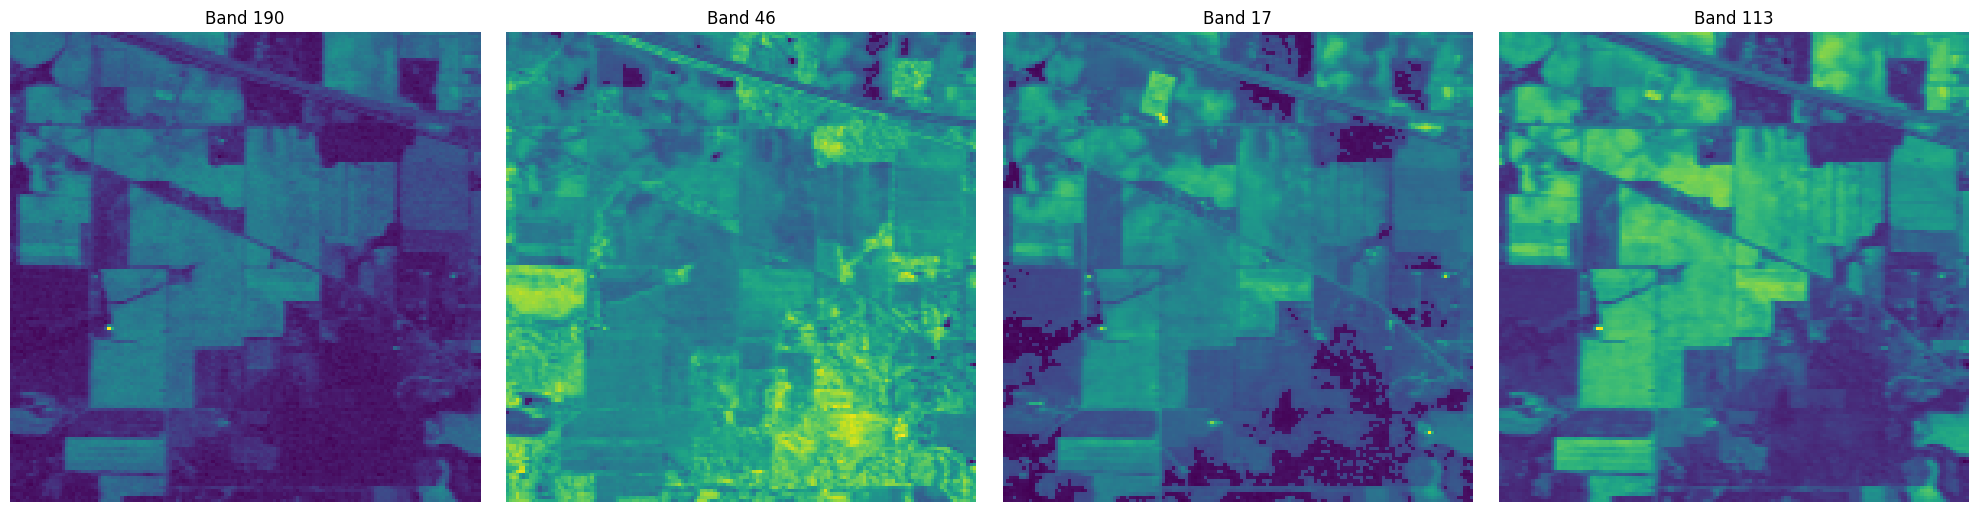

In [8]:
import random

num_bands_to_visualize = 4  # Specify the number of bands to visualize
selected_bands = random.sample(range(data_set.shape[2]), num_bands_to_visualize)  # Randomly select bands

fig, axs = plt.subplots(1, num_bands_to_visualize, figsize=(20, 5))  # Create subplots for selected bands

for i, band_idx in enumerate(selected_bands):
    axs[i].imshow(data_set[:, :, band_idx])  # Plot each selected band
    axs[i].set_title(f"Band {band_idx+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

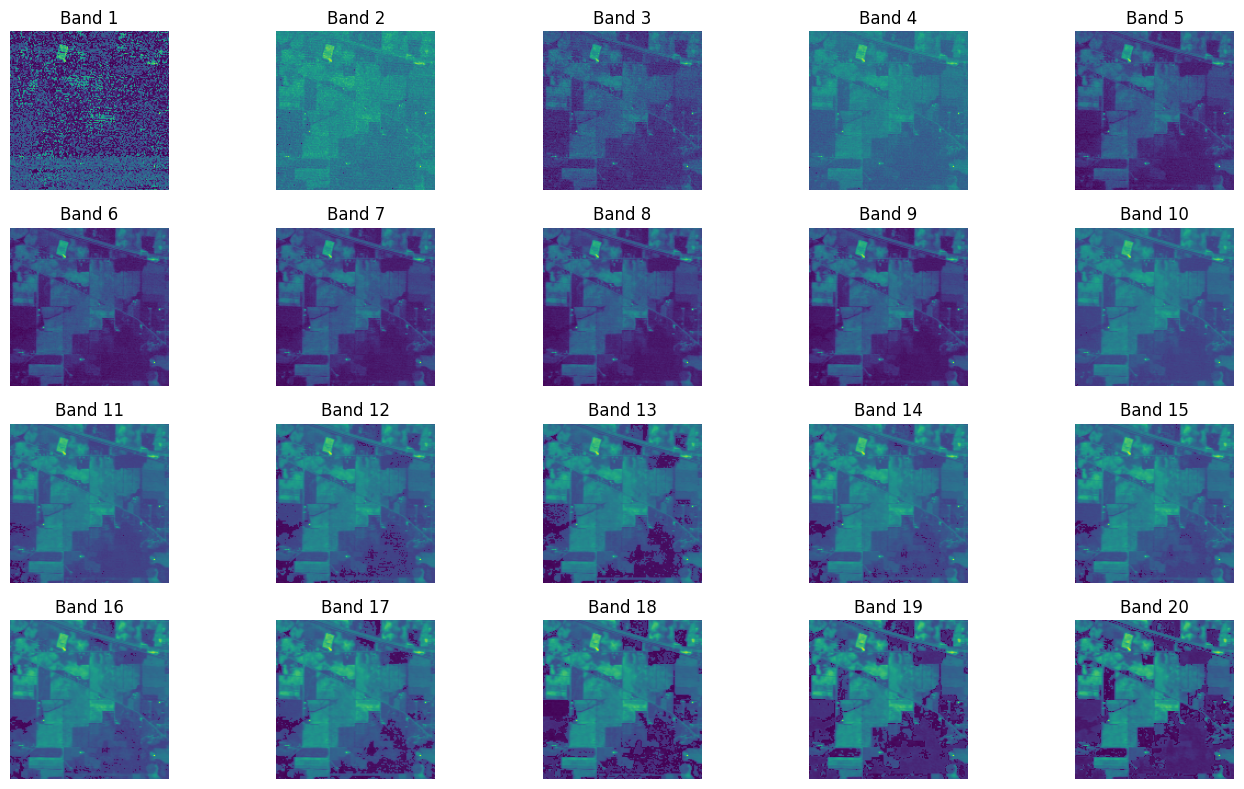

In [9]:
plt.figure(figsize=(14, 8))
for i in range(20):  # Adjust as needed
    plt.subplot(4, 5, i + 1)
    plt.imshow(data_set[:, :, i])
    plt.title(f"Band {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

visualizing output ground truth-Indian Pines

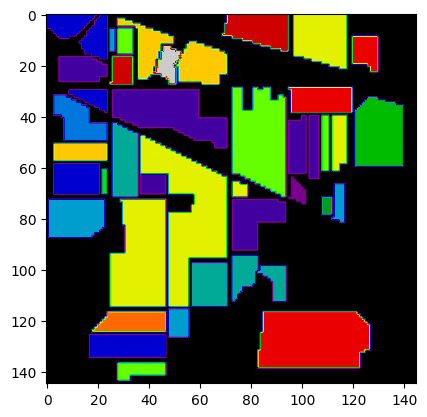

In [10]:

plt.imshow(gt,cmap='nipy_spectral')

----UNTIL THIS POINT WE FINISH LOADING THE DATA,EXPLORING IT AND VISUALIZATION PROPERLY FOR INDIAN PINES---

DATA PREPROCESSING

DATA STANDARDIZATION

In [11]:
from sklearn.preprocessing import StandardScaler
# Reshape dataset if needed
data_set_reshaped = data_set.reshape(-1, data_set.shape[2])

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to your dataset and transform it
data_set_standardized = scaler.fit_transform(data_set_reshaped)

# Reshape the standardized dataset back to its original shape
data_set_standardized = data_set_standardized.reshape(data_set.shape)


PCA

In [12]:
from sklearn.decomposition import PCA

def reduce_dim(img_data, n_components=0.95):
    """
    Reduces spectral dimension of image data using PCA.
    
    Arguments
    ---------
    img_data : numpy.ndarray, shape (height, width, bands)
        Contains image data.
        
    n_components : float or int, optional (default=0.95)
        If float, represents the minimum fraction of variance explained by
        the components. If integer, represents the number of components.
        
    Returns
    -------
    img_data_transformed : numpy.ndarray, shape (height, width, n_components)
        Transformed data after dimensionality reduction.
    """
    
    # Reshape the input data to 2D array (height*width, bands)
    height, width, bands = img_data.shape
    img_data_2d = img_data.reshape(-1, bands)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    img_data_transformed_2d = pca.fit_transform(img_data_2d)
    
    # Reshape the transformed data back to 3D array
    img_data_transformed = img_data_transformed_2d.reshape(height, width, -1)
    
    return img_data_transformed

# Apply PCA to your dataset
n_components = 0.999 # Adjust as needed
data_set_pca = reduce_dim(data_set_standardized, n_components=n_components)

In [13]:
data_set_pca.shape

(145, 145, 108)

DATA AUGUMENTATION

In [14]:
from scipy.ndimage import rotate

X_indian_pines = [] #data
Y_indian_pines = [] #labels

step = 5
x = range(0, 145, step)
y = range(0, 145, step)

for i in x:
    for j in y:
        _data = data_set_pca[i:i+step, j:j+step]  # Extracting a patch of size (step x step)

        # Augmentations: original, flipped vertically, flipped horizontally, rotated 90 degrees clockwise, rotated 90 degrees counterclockwise
        aug_data = [_data, np.flip(_data, 0), np.flip(_data, 1), rotate(_data, 90), rotate(_data, -90)]
        X_indian_pines.extend(aug_data)

        # Extracting the label from the center pixel
        center_i = i + step // 2
        center_j = j + step // 2
        label = gt[center_i, center_j]

        # Repeating the label for each augmented instance
        Y_indian_pines.extend([label] * 5)

#convert them to np arrays from lists
X_indian_pines = np.array(X_indian_pines)
Y_indian_pines = np.array(Y_indian_pines)

print(X_indian_pines.shape)
print(Y_indian_pines.shape)

(4205, 5, 5, 108)
(4205,)


----DATA AUGUMENTATION,STANDARDIZATION,PCA AND ITS VISUALIZATION IS DONE----

SPLITTING TEST AND TRAIN

In [15]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indian_pines, Y_indian_pines, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3364, 5, 5, 108)
(841, 5, 5, 108)
(3364,)
(841,)


ENCODING Y SET

In [17]:
from tensorflow.keras.utils import to_categorical

# y_train is a single column of class labels
y_train_one_hot = to_categorical(y_train, num_classes=17)
y_test_one_hot = to_categorical(y_test, num_classes=17)

MODELS IMPLEMENTATION FROM THIS POINT ONWARD

2D CNN MODEL ARCHITECTURE

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming X_train is your input data and y_train is the corresponding labels

# Define the 2D CNN model
model2d = Sequential()

# Convolutional layers
model2d.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(5, 5, 108), padding='same'))
model2d.add(MaxPooling2D(pool_size=(1, 1)))

# Add another Conv2D layer
model2d.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2d.add(MaxPooling2D(pool_size=(1, 1)))

# Flatten or reshape the output from the 2D layers
model2d.add(Flatten())

# Fully connected layers
model2d.add(Dense(64, activation='relu'))
model2d.add(Dense(128, activation='relu'))

# Output layer
model2d.add(Dense(17, activation='softmax'))  # Assuming 17 classes, adjust as needed

# Compile the model
model2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 32)          86432     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 64)                3

train the 2d cnn model

In [21]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model2d.fit(X_train, y_train_one_hot,
                    epochs=10,
                    validation_data=(X_test, y_test_one_hot))

Epoch 1/10
106/106 [==============================] - 2s 10ms/step - loss: 1.1464 - accuracy: 0.6296 - val_loss: 0.7145 - val_accuracy: 0.7491
Epoch 2/10
106/106 [==============================] - 1s 8ms/step - loss: 0.4893 - accuracy: 0.8237 - val_loss: 0.5055 - val_accuracy: 0.8086
Epoch 3/10
106/106 [==============================] - 1s 9ms/step - loss: 0.2825 - accuracy: 0.9022 - val_loss: 0.5383 - val_accuracy: 0.8169
Epoch 4/10
106/106 [==============================] - 1s 8ms/step - loss: 0.1299 - accuracy: 0.9554 - val_loss: 0.4388 - val_accuracy: 0.8395
Epoch 5/10
106/106 [==============================] - 1s 8ms/step - loss: 0.0628 - accuracy: 0.9822 - val_loss: 0.2698 - val_accuracy: 0.9156
Epoch 6/10
106/106 [==============================] - 1s 10ms/step - loss: 0.0851 - accuracy: 0.9727 - val_loss: 0.2680 - val_accuracy: 0.9037
Epoch 7/10
106/106 [==============================] - 1s 9ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.2290 - val_accuracy: 0.9203
Epoc

Let us plot losses and accuracy

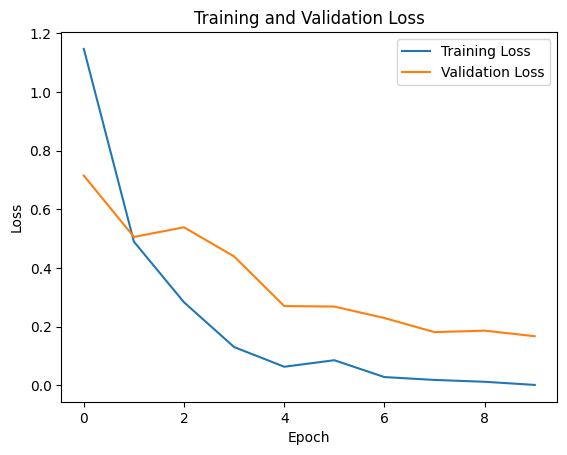

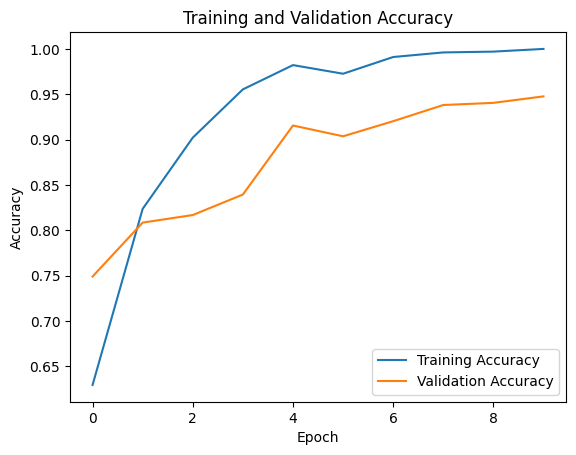

In [22]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Let us write a function to predict

In [23]:
# Function to predict labels using the trained model
def predict_labels(model, X_data):
    y_pred = np.argmax(model.predict(X_data), axis=1)
    return y_pred

Predict using 2D MODEL - CHECKPOINT 1


In [36]:
# Predict labels for testing data
y_test_pred = predict_labels(model2d, X_test)

27/27 [==============================] - 0s 3ms/step


In [37]:
y_test_pred_one_hot = to_categorical(y_test_pred, num_classes=17)

In [38]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_one_hot,y_test_pred_one_hot))

0.9476813317479191


EVALUATION 


EVALUATE MODEL to check test and train accuracy

In [28]:
# Evaluate the model on the test set
loss, accuracy = model2d.evaluate(X_test, y_test_one_hot)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model2d.evaluate(X_train, y_train_one_hot)

print(f'Train Loss: {loss:.4f}')
print(f'Train Accuracy: {accuracy*100:.2f}%')

27/27 [==============================] - 0s 3ms/step - loss: 0.1669 - accuracy: 0.9477
Test Loss: 0.1669
Test Accuracy: 94.77%
106/106 [==============================] - 0s 2ms/step - loss: 4.1216e-04 - accuracy: 1.0000
Train Loss: 0.0004
Train Accuracy: 100.00%


3D CNN MODEL ARCHITECTURE

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

# Assuming X_train is your input data and y_train is the corresponding labels

# Reshape the data for 3D CNN
X_train_reshaped = X_train.reshape(-1, 5, 5, 108, 1)


# Define the 3D CNN model
model3d = Sequential()
model3d.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(5, 5, 108, 1)))
model3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3d.add(Flatten())
model3d.add(Dense(64, activation='relu'))
model3d.add(Dense(128, activation='relu'))
model3d.add(Dense(17, activation='softmax'))  # Adjust for the number of classes in your task

# Compile the model
model3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model3d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 3, 106, 32)     896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 1, 53, 32)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1696)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                108608    
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 17)                2193      
                                                      

lets train the 3d cnn model

In [40]:
history2=model3d.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
85/85 [==============================] - 3s 29ms/step - loss: 1.5949 - accuracy: 0.5530 - val_loss: 1.1468 - val_accuracy: 0.6107
Epoch 2/10
85/85 [==============================] - 2s 22ms/step - loss: 1.0637 - accuracy: 0.6302 - val_loss: 0.8782 - val_accuracy: 0.6880
Epoch 3/10
85/85 [==============================] - 2s 22ms/step - loss: 0.7615 - accuracy: 0.7261 - val_loss: 0.7627 - val_accuracy: 0.7400
Epoch 4/10
85/85 [==============================] - 2s 23ms/step - loss: 0.6232 - accuracy: 0.7763 - val_loss: 0.6158 - val_accuracy: 0.7741
Epoch 5/10
85/85 [==============================] - 2s 24ms/step - loss: 0.4962 - accuracy: 0.8179 - val_loss: 0.6065 - val_accuracy: 0.7652
Epoch 6/10
85/85 [==============================] - 2s 23ms/step - loss: 0.4248 - accuracy: 0.8395 - val_loss: 0.5010 - val_accuracy: 0.8024
Epoch 7/10
85/85 [==============================] - 2s 23ms/step - loss: 0.3126 - accuracy: 0.8881 - val_loss: 0.3554 - val_accuracy: 0.8752
Epoch 8/10
85

lets plot loss and accuracy

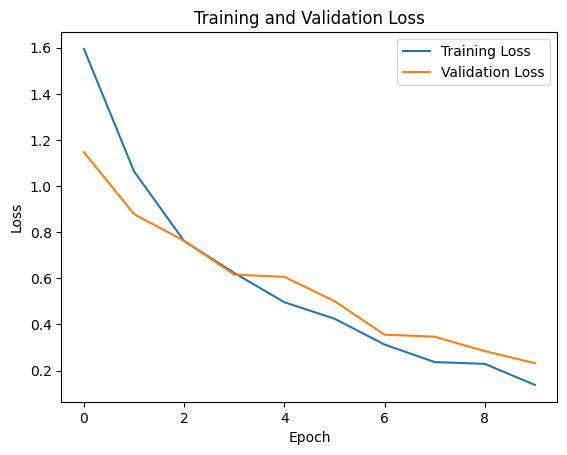

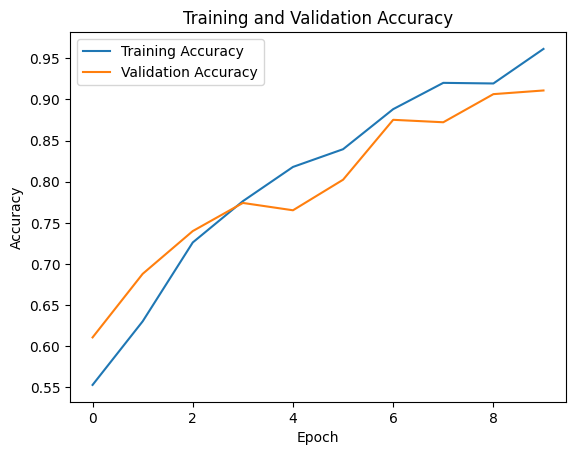

In [41]:
# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

reshape X_test also to evaluate on test dataset

In [42]:
X_test_reshaped = X_test.reshape(-1, 5, 5, 108, 1)

Evaluation of the 3D CNN model on test data 

In [44]:
# Evaluate the model on the test data
test_loss, test_accuracy = model3d.evaluate(X_test_reshaped, y_test_one_hot)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

loss, accuracy = model3d.evaluate(X_train_reshaped, y_train_one_hot)

print(f'Train Loss: {loss:.4f}')
print(f'Train Accuracy: {accuracy*100:.2f}%')


27/27 [==============================] - 0s 7ms/step - loss: 0.2845 - accuracy: 0.8977
Test Loss: 0.2844869792461395
Test Accuracy: 0.8977407813072205
106/106 [==============================] - 1s 6ms/step - loss: 0.1423 - accuracy: 0.9542
Train Loss: 0.1423
Train Accuracy: 95.42%


Predict on new test dataset

In [49]:
def predict_labels(model, X_data):
    y_pred = np.argmax(model.predict(X_data), axis=1)
    return y_pred
# Predict labels for training and testing data
y_train_pred3d = predict_labels(model3d, X_train_reshaped)
y_test_pred3d = predict_labels(model3d, X_test_reshaped)

27/27 [==============================] - 0s 8ms/step


In [50]:
y_test_pred_one_hot3d = to_categorical(y_test_pred3d, num_classes=17)

In [51]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_one_hot,y_test_pred_one_hot3d))

0.8977407847800237


1D CNN

In [52]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define architecture parameters
kernel_size = 3  # Kernel size for convolutional layers
pool_size = 2    # Pool size for max pooling layers
filters = 64     # Number of filters in convolutional layers
dense_units = 128  # Number of units in dense layers

# Initialize the model
model = Sequential()

# Add convolutional layer
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(25,108)))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=pool_size))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add dense layers
model.add(Dense(units=dense_units, activation='relu'))

# Output layer
model.add(Dense(units=17, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            20800     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 704)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               90240     
                                                                 
 dense_7 (Dense)             (None, 17)                2193      
                                                                 
Total params: 113,233
Trainable params: 113,233
Non-trainable params: 0
________________________________________________

RESHAPING X_TRAIN AND X_TEST FOR 1D CNN

In [53]:
X_train_1d = X_train.reshape(X_train.shape[0], -1, X_train.shape[-1])
print(X_train_1d.shape)
X_test_1d = X_test.reshape(X_test.shape[0], -1, X_test.shape[-1])
print(X_test_1d.shape)

(3364, 25, 108)
(841, 25, 108)


In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history1d=model.fit(X_train_1d, y_train_one_hot, epochs=10, validation_data=(X_test_1d, y_test_one_hot))

Epoch 1/10
106/106 [==============================] - 1s 5ms/step - loss: 0.1255 - accuracy: 0.6058 - val_loss: 0.0915 - val_accuracy: 0.6968
Epoch 2/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.7556 - val_loss: 0.0685 - val_accuracy: 0.7860
Epoch 3/10
106/106 [==============================] - 0s 4ms/step - loss: 0.0538 - accuracy: 0.8430 - val_loss: 0.0551 - val_accuracy: 0.8288
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0394 - accuracy: 0.8864 - val_loss: 0.0496 - val_accuracy: 0.8633
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 0.9269 - val_loss: 0.0411 - val_accuracy: 0.8847
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9652 - val_loss: 0.0368 - val_accuracy: 0.8835
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9804 - val_loss: 0.0352 - val_accuracy: 0.8942
Epoch 

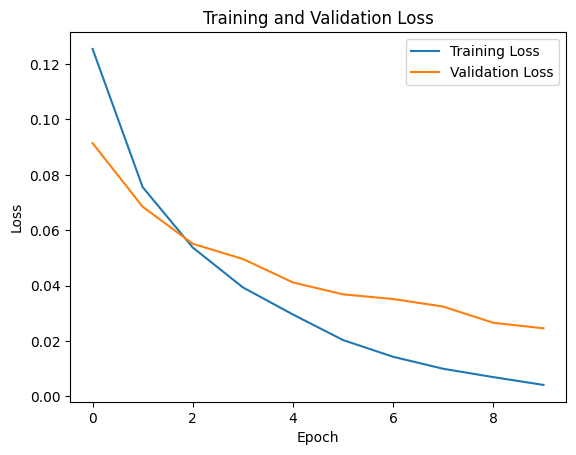

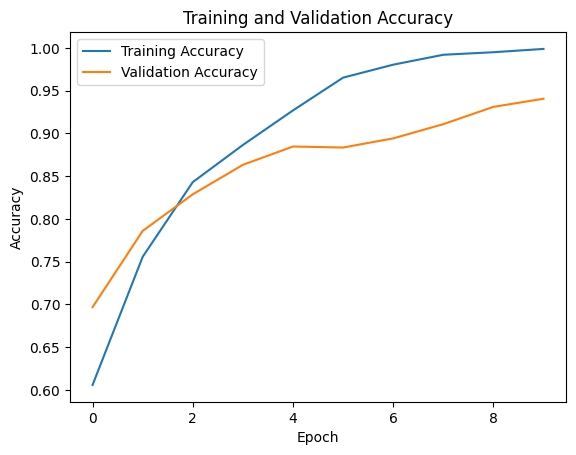

In [57]:
# Plot training and validation loss
plt.plot(history1d.history['loss'], label='Training Loss')
plt.plot(history1d.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history1d.history['accuracy'], label='Training Accuracy')
plt.plot(history1d.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

EVALUATINg THE 1D CNN MODEL ON TEST SET AND CALCULATING ITS ACCURACY

In [59]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_1d, y_test_one_hot)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

loss, accuracy = model.evaluate(X_train_1d, y_train_one_hot)

print(f'Train Loss: {loss:.4f}')
print(f'Train Accuracy: {accuracy*100:.2f}%')

27/27 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9405
Test Loss: 0.024588150903582573
Test Accuracy: 0.940546989440918
106/106 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Train Loss: 0.0029
Train Accuracy: 100.00%


X_train,X_test is for 2dcnn


X_train_reshaped,X_test_reshaped is for 3d cnn


X_train_1d,X_test_1d is for 1dcnn

In [61]:
import numpy as np

# Function to predict labels using the trained model
def predict_labels(model, X_test_1d):
    y_pred = np.argmax(model.predict(X_test_1d), axis=1)
    return y_pred

# Predict labels for training and testing data
y_train_pred1d = predict_labels(model, X_train_1d)
y_test_pred1d = predict_labels(model, X_test_1d)

27/27 [==============================] - 0s 1ms/step


In [62]:
y_test_pred_one_hot1d = to_categorical(y_test_pred1d, num_classes=17)

In [63]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_one_hot,y_test_pred_one_hot1d))

0.9405469678953626


HYBRID SN MODEL ARCHITECTURE

Check shape of X_train and Y_train

In [68]:
X_test_reshaped=X_test.reshape(-1, 5, 5, 108, 1)

In [64]:
print(X_train_reshaped.shape)
print(y_train_one_hot.shape)

(3364, 5, 5, 108, 1)
(3364, 17)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Reshape, Flatten, Dense, Dropout, Attention, Add, BatchNormalization,MaxPooling3D
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2




input_shape = Input(shape=(5,5,108,1))


cnv3d1=Conv3D(32,kernel_size=(3,3,3),activation='relu',padding='same')(input_shape)
cnv3d2=Conv3D(64,kernel_size=(5,5,5),activation='relu',padding='same')(cnv3d1)
maxpl3d=MaxPooling3D(pool_size=(2, 2, 2))(cnv3d2)
cnv3d3=Conv3D(128,kernel_size=(5,5,5),activation='relu',padding='same')(maxpl3d)


cnv3d3_shape=cnv3d3.shape

reshapelayer= Reshape((cnv3d3_shape[1], cnv3d3_shape[2], cnv3d3_shape[3]*cnv3d3_shape[4]))(cnv3d3)


#print(reshapelayer.shape)
cnv2d1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(reshapelayer)

print(cnv2d1.shape)

flatten_layer = Flatten()(cnv2d1)

dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=17, activation='softmax')(dense_layer2)


modelsn = Model(inputs=input_shape, outputs=output_layer)
modelsn.summary()




(None, 2, 2, 64)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 108, 1)]    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 5, 108, 32)     896       
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 5, 108, 64)     256064    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 2, 54, 64)     0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 2, 2, 54, 128)     1024128   
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 6912)        0         
                                          

In [74]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001, decay=1e-06)
modelsn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [75]:
tf.device("/gpu:0")

In [76]:
historysn=modelsn.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

Epoch 1/10
106/106 [==============================] - 339s 3s/step - loss: 1.8347 - accuracy: 0.5086
Epoch 2/10
106/106 [==============================] - 399s 4s/step - loss: 1.3003 - accuracy: 0.5764
Epoch 3/10
106/106 [==============================] - 392s 4s/step - loss: 0.8325 - accuracy: 0.7235
Epoch 4/10
106/106 [==============================] - 389s 4s/step - loss: 0.4263 - accuracy: 0.8564
Epoch 5/10
106/106 [==============================] - 392s 4s/step - loss: 0.2123 - accuracy: 0.9236
Epoch 6/10
106/106 [==============================] - 395s 4s/step - loss: 0.0711 - accuracy: 0.9756
Epoch 7/10
106/106 [==============================] - 391s 4s/step - loss: 0.0517 - accuracy: 0.9890
Epoch 8/10
106/106 [==============================] - 403s 4s/step - loss: 0.0639 - accuracy: 0.9804
Epoch 9/10
106/106 [==============================] - 405s 4s/step - loss: 0.0666 - accuracy: 0.9831
Epoch 10/10
106/106 [==============================] - 405s 4s/step - loss: 0.0438 - accura

Evaluate the Hybrid SN model on test set

In [78]:
overall_accuracy = modelsn.evaluate(X_test_reshaped, y_test_one_hot)[1]
print("Overall Accuracy:", overall_accuracy)

27/27 [==============================] - 5s 182ms/step - loss: 0.0149 - accuracy: 0.9952
Overall Accuracy: 0.9952437281608582


In [79]:
# Assuming you have trained your model and have test data available
# Make predictions on the test data
y_pred = modelsn.predict(X_test_reshaped)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)  # Assuming y_test is one-hot encoded

# Calculate test accuracy
test_accuracy = np.mean(y_pred_labels == y_true_labels)



print("Test Accuracy thru prediction:", test_accuracy)


27/27 [==============================] - 5s 186ms/step
Test Accuracy thru prediction: 0.995243757431629


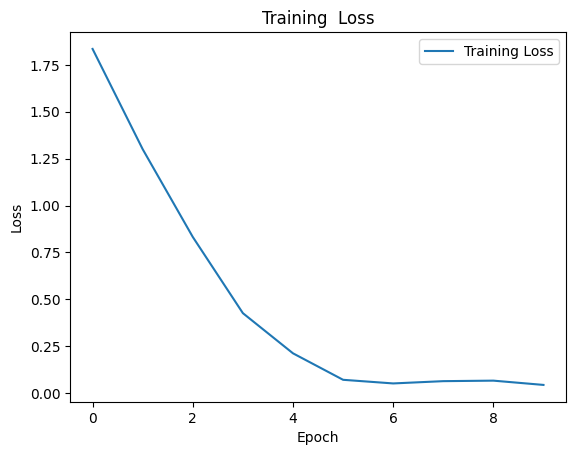

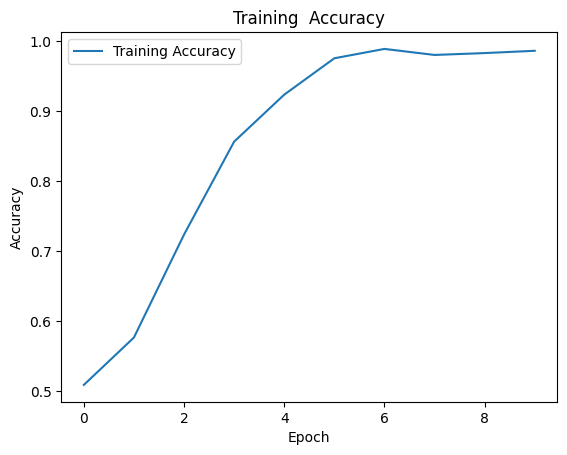

In [83]:
# Plot training and validation loss
plt.plot(historysn.history['loss'], label='Training Loss')
#plt.plot(historysn.history['val_loss'], label='Validation Loss')
plt.title('Training  Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(historysn.history['accuracy'], label='Training Accuracy')
#plt.plot(historysn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()